In [4]:
import argparse
import logging.config
import os
from collections import defaultdict

from dotenv import load_dotenv

from rescueclip.logging_config import LOGGING_CONFIG

logging.config.dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
from pathlib import Path

import time

import numpy as np
from typing import cast, Sequence, List, Any, Literal
import weaviate
from tqdm import tqdm
from weaviate.classes.query import Filter, MetadataQuery
from weaviate.collections.classes.types import Properties, WeaviateProperties
from weaviate.collections.classes.internal import Object
from weaviate.util import generate_uuid5, get_vector

from rescueclip import cuhk
from rescueclip.cuhk import SetNumToImagesMap
from rescueclip.ml_model import (
    CollectionConfig,
    CUHK_Apple_Collection,
    CUHK_Google_Siglip_Base_Patch16_224_Collection,
    CUHK_Google_Siglip_SO400M_Patch14_384_Collection,
    CUHK_laion_CLIP_ViT_bigG_14_laion2B_39B_b160k_Collection,
    CUHK_MetaCLIP_ViT_bigG_14_quickgelu_224_Collection,
    CUHK_ViT_B_32_Collection,
)
from rescueclip.weaviate import WeaviateClientEnsureReady

load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
collection_config = CUHK_Apple_Collection
client = WeaviateClientEnsureReady().get_client()
collection = client.collections.get(collection_config.name)
QUERY_MAXIMUM_RESULTS = 200_000

number_of_objects: int = collection.aggregate.over_all(total_count=True).total_count # type: ignore
logger.info(f"Number of objects %s", number_of_objects)
assert (
    number_of_objects <= QUERY_MAXIMUM_RESULTS 
), "Ensure docker-compose.yml has QUERY_MAXIMUM_RESULTS to greater than 200_000 or the experiment's results may be inaccurate"

2025-02-24 02:21:32,631 [INFO] rescueclip.weaviate: Weaviate is ready
2025-02-24 02:21:32,638 [INFO] __main__: Number of objects 18596


/scratch3/atharva/anaconda3/envs/rescueCLIP/lib/python3.12/site-packages/weaviate/warnings.py:314: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(


In [ ]:
# Train test split
logger.info("Retrieving the entire database into memory")
objects = collection.query.fetch_objects(
    limit=QUERY_MAXIMUM_RESULTS,
    include_vector=True,
    return_properties=True,
).objects
assert len(objects) == number_of_objects, "Expected the entire database to be retrieved"

objects.sort(key=lambda obj: (obj.properties["set_number"], obj.properties["file_name"]))

##### TEMPORARITY MAKE DATASET SMALLER
# objects = objects[:4*4] # 4 sets of 4 images each
#####

# (N, D)
X = np.array([obj.vector["embedding"] for obj in objects])
y_set_labels = np.array([obj.properties["set_number"] for obj in objects])
N = X.shape[0]
logger.info(f"N: {N}")
assert y_set_labels.shape[0] == N, "Expected the number of objects to match the number of set labels"

##### TEMPORARITY ASSERTIONS
# assert N == 4*4, "Expected 16 objects"
# assert y_set_labels.shape[0] == 4*4, "Expected 16 objects"
# assert (np.unique(y_set_labels) == np.array([1, 4, 8, 9])).all(), "Expected the set labels to be 0, 1, 2, 3, got {}".format(np.unique(y_set_labels))
#####

logger.info(f"X.shape: {X.shape}")
logger.info(f"y_set_labels.shape: {y_set_labels.shape}")

2025-02-24 02:21:32,705 [INFO] __main__: Retrieving the entire database into memory


/scratch3/atharva/anaconda3/envs/rescueCLIP/lib/python3.12/asyncio/selector_events.py:879: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=71 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


2025-02-24 02:21:36,220 [INFO] __main__: N: 18596
2025-02-24 02:21:36,223 [INFO] __main__: X.shape: (18596, 1024)
2025-02-24 02:21:36,223 [INFO] __main__: y_set_labels.shape: (18596,)


In [7]:
assert N % 2 == 0, "Can't evenly split the data into train and test sets"
# (N//2, D)
X_train_vectors = X[:N//2, :]
# (N//2, D)
X_test_vectors = X[N//2:, :]

logger.info(f"X_train_vectors.shape: {X_train_vectors.shape}")
logger.info(f"X_test_vectors.shape: {X_test_vectors.shape}")

2025-02-24 02:21:36,270 [INFO] __main__: X_train_vectors.shape: (9298, 1024)
2025-02-24 02:21:36,271 [INFO] __main__: X_test_vectors.shape: (9298, 1024)


In [8]:
from scipy.spatial.distance import cdist

X_train_distances = cdist(X_train_vectors, X_train_vectors, metric='cosine')
y_train_labels = y_set_labels[:N//2]

logger.info("X_train_distances.shape: {}".format(X_train_distances.shape))
logger.info("y_train_labels.shape: {}".format(y_train_labels.shape))

2025-02-24 02:22:52,518 [INFO] __main__: X_train_distances.shape: (9298, 9298)
2025-02-24 02:22:52,520 [INFO] __main__: y_train_labels.shape: (9298,)


In [ ]:
print(f"{X_train_distances[:5, :5]=}")
print(f"{y_train_labels[:5]}")

X_train_distances[:5, :5]
[[0.         0.15403616 0.1994384  0.37220493 0.31865613]
 [0.15403616 0.         0.12657806 0.34442987 0.36794799]
 [0.1994384  0.12657806 0.         0.28237242 0.30409882]
 [0.37220493 0.34442987 0.28237242 0.         0.35346233]
 [0.31865613 0.36794799 0.30409882 0.35346233 0.        ]]
[1 1 1 1 4]


In [10]:
X_test_distances = cdist(X_train_vectors, X_test_vectors, metric='cosine')
y_test_labels = y_set_labels[N//2:]

logger.info(f"X_test_distances.shape: {X_test_distances.shape}")
logger.info(f"y_test_labels.shape: {y_test_labels.shape}")

2025-02-24 02:24:08,848 [INFO] __main__: X_test_distances.shape: (9298, 9298)
2025-02-24 02:24:08,851 [INFO] __main__: y_test_labels.shape: (9298,)


In [11]:
try:
    del X
    del y_set_labels
except:
    pass

In [12]:
# For train data
sorted_indexes = np.argsort(X_train_distances, axis=1)
print(f"{sorted_indexes[:8, :8]=}")
assertion_cond = (np.arange(N//2) == sorted_indexes[:, 0])
if not np.all(assertion_cond):
    false_indices = np.flatnonzero(~assertion_cond)
    logger.info(f"Fixing distances at positions: {false_indices}")
    for false_index in false_indices:
        logger.info(f"Swapping index: {false_index}")
        temp = sorted_indexes[false_index, 0]
        sorted_indexes[false_index, 0] = sorted_indexes[false_index, 1]
        sorted_indexes[false_index, 1] = temp
    assertion_cond = (np.arange(N//2) == sorted_indexes[:, 0])
    if not np.all(assertion_cond):
        false_indices = np.flatnonzero(~assertion_cond)
        assert False, f"Expected the first column of the sorted indexes to be the same as the original indexes\n{false_indices=}\n{sorted_indexes[false_indices[0] - 3:false_indices[0] + 3, :]=}"

X_train_distances = np.take_along_axis(X_train_distances, sorted_indexes, axis=1)
y_train_labels_mat = y_train_labels[sorted_indexes]
del sorted_indexes
print(f"{X_train_distances[:5, :5]=}")
print(f"{y_train_labels_mat[:8, :8]=}")

logger.info(f"X_train_distances.shape: {X_train_distances.shape}")
logger.info(f"y_set_labels_mat.shape: {y_train_labels_mat.shape}")


sorted_indexes[:8, :8]=array([[   0, 1411,  487, 5636,    1, 5010, 4696, 7506],
       [   1, 3491, 3201, 6317, 2771, 4297,    2, 5816],
       [   2, 7489, 8574, 1484, 3200, 5817, 4298, 2025],
       [   3, 3343, 2050, 3579, 7767, 6722, 4007, 5282],
       [   4, 6900, 4868, 3822, 4783, 3076, 7404, 5922],
       [   5,  373, 6352,    6, 7279,  372,  224, 6353],
       [   6, 6353,  224, 5714,    5,  375, 6354, 6648],
       [   7, 8971, 3715, 1959, 1958, 2262,  227,    4]])
2025-02-24 02:24:10,602 [INFO] __main__: Fixing distances at positions: [2488 2793 2794 3399 5237 5416 5476 7725 8347 8945]
2025-02-24 02:24:10,603 [INFO] __main__: Swapping index: 2488
2025-02-24 02:24:10,604 [INFO] __main__: Swapping index: 2793
2025-02-24 02:24:10,604 [INFO] __main__: Swapping index: 2794
2025-02-24 02:24:10,605 [INFO] __main__: Swapping index: 3399
2025-02-24 02:24:10,606 [INFO] __main__: Swapping index: 5237
2025-02-24 02:24:10,606 [INFO] __main__: Swapping index: 5416
2025-02-24 02:24:10,607 

In [ ]:
# For test distances
sorted_indexes = np.argsort(X_test_distances, axis=1)
print(f"{sorted_indexes[:8, :8]=}")

X_test_distances = np.take_along_axis(X_test_distances, sorted_indexes, axis=1)
y_test_labels_mat = y_test_labels[sorted_indexes]
del sorted_indexes
print(f"{X_test_distances[:5, :5]=}")
print(f"{y_test_labels_mat[:8, :8]=}")

logger.info(f"X_test_distances.shape: {X_test_distances.shape}")
logger.info(f"y_test_labels_mat.shape: {y_test_labels_mat.shape}")

[[ 226  429 4441 1757 2181 5471 5530 1528]
 [7124 4798 4829 8898 8286 7123 3091 8287]
 [2703 3112 2968 8671 4109 5355 4799 4511]
 [3705 7361 7437 3756 6849 8080 5651 8985]
 [6745 6055 6742 9248 4598 9152 1633 1632]
 [4286 5566 6743 8423 1630 2090 9246 1347]
 [4288  655 1632 9247 4789 2091 1630 8424]
 [6205 5145 4742 6204 6745  145 1632 4601]]
[[0.14270019 0.15325238 0.15865978 0.16644472 0.16734573]
 [0.10827802 0.11412352 0.12063116 0.12216119 0.12355196]
 [0.07889354 0.09941126 0.10033786 0.10130416 0.10301782]
 [0.14301369 0.15255575 0.15456978 0.16176671 0.16790703]
 [0.09705455 0.09755191 0.09822653 0.10485656 0.10847885]]
[[ 6630  6777  9683  7768  8082 10388 10422  7579]
 [11531  9929  9957 12717 12271 11531  8690 12271]
 [ 8428  8708  8599 12543  9446 10302  9929  9737]
 [ 9152 11675 11732  9193 11387 12157 10531 12792]
 [11320 10810 11320 12966  9795 12901  7658  7658]
 [ 9581 10456 11320 12367  7658  8020 12966  7449]
 [ 9581  6928  7658 12966  9914  8020  7658 12367]
 [10922

In [14]:
def compute_result_naive(X, y_set_labels_mat, y_set_labels, t, is_train: bool):
    N = X.shape[0]
    result = np.zeros(N, dtype=int)
    
    for i in range(N):
        # Since X[i] is sorted in ascending order, find the cutoff index.
        # This returns the index at which t should be inserted to maintain order,
        # meaning all indices below this are <= t.
        k = np.searchsorted(X[i], t, side='right')
        
        # Get the labels for these positions
        selected_labels = y_set_labels_mat[i, :k]
        
        # Count how many times the label equals y_set_labels[i]
        count = np.sum(selected_labels == y_set_labels[i])

        # If is train, and t is suffiently large, make sure than the count is at least 1
        if is_train and t > 0.05:
            assert count >= 1, f"count: {count}, t: {t}, i: {i}, k: {k}"
        
        # If the count is at least 2, set result[i] to 1
        if count >= 2:
            result[i] = 1
            
    return result

def compute_result_vectorized(X, y_set_labels_mat, y_set_labels, t, is_train):
    # Create a mask where each element is True if X[i, j] <= t.
    mask_threshold = X <= t  # shape (N, N)
    
    # Create a mask where each element is True if y_set_labels_mat[i, j] equals y_set_labels[i].
    label_match = (y_set_labels_mat == y_set_labels[:, np.newaxis])
    
    # Combine the masks to consider only the positions meeting both conditions.
    combined_mask = mask_threshold & label_match
    
    # Count the matches in each row.
    count = np.sum(combined_mask, axis=1)

    # If is train, and t is suffiently large, make sure than the count is at least 1
    if is_train and t > 0.05:
        assertion_cond = count >= 1
        if not np.all(assertion_cond):
            false_indices = np.flatnonzero(~assertion_cond)
            assert False, f"count: {count}, t: {t}, at index: {false_indices[0]}"
    
    # Result is 1 if count >= 2, else 0.
    result = (count >= 2).astype(int)
    return result

In [15]:
from dataclasses import dataclass

@dataclass
class ConfusionMatrix:
    tp: int | np.floating = 0
    tn: int | np.floating = 0
    fp: int | np.floating = 0
    fn: int | np.floating = 0

    def update(self, *, tp: int | np.floating = 0, tn: int | np.floating = 0, fp: int | np.floating = 0, fn: int | np.floating = 0):
        self.tp += tp
        self.tn += tn
        self.fp += fp
        self.fn += fn

    def as_array(self):
        # Returns a 2x2 array: [[tn, fp], [fn, tp]]
        return [[self.tn, self.fp], [self.fn, self.tp]]
    
    # how often predictions for the positive class are correct
    def precision(self):
        if self.tp + self.fp == 0:
            return 0.0
        return self.tp / (self.tp + self.fp)

    # proportion of all actual positives (in the DB) that were classified correctly as positives
    def recall(self):
        if self.tp + self.fn == 0:
            return 0.0
        return self.tp / (self.tp + self.fn)

    def f1(self):
        prec = self.precision()
        rec = self.recall()
        if prec + rec == 0:
            return 0.0
        return 2 * (prec * rec) / (prec + rec)
    
    # the probability of a test incorrectly identifying a negative result (not in DB) as positive
    def fpr(self):
        if self.fp + self.tn == 0:
            return 0.0
        return self.fp / (self.fp + self.tn)
    
    def __str__(self):
        return f"TP: {self.tp}, TN: {self.tn}, FP: {self.fp}, FN: {self.fn}"



In [16]:
def threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels) -> ConfusionMatrix:
    # Training results
    training_set_results = compute_result_naive(X_train_distances, y_train_labels_mat, y_train_labels, t, True)
    assert training_set_results.shape[0] == X_train_distances.shape[0] == y_train_labels_mat.shape[0] == y_train_labels.shape[0], f"Dimension check failed {training_set_results.shape[0]=} {X_train_distances.shape[0]=} {y_train_labels_mat.shape[0]=} {y_train_labels.shape[0]=}"

    training_counts = np.unique_counts(training_set_results)
    assert len(training_counts.counts) <= 2, f"Expected <= 2 values, got {training_counts}"

    # Testing results
    test_set_results = compute_result_naive(X_test_distances, y_test_labels_mat, y_test_labels, t, False)
    assert test_set_results.shape[0] == X_test_distances.shape[0] == y_test_labels_mat.shape[0] == y_test_labels.shape[0], f"Dimension check failed {test_set_results.shape[0]=} {X_test_distances.shape[0]=} {y_test_labels_mat.shape[0]=} {y_test_labels.shape[0]=}"

    testing_counts = np.unique_counts(test_set_results)
    assert len(testing_counts.counts) <= 2, f"Expected <= 2 values, got {testing_counts}"

    # Confusion matrix
    cm = ConfusionMatrix()
    if len(training_counts.counts) == 2:
        tp = training_counts.counts[1]
        fn = training_counts.counts[0]
    elif len(training_counts.counts) == 1:
        count_for = training_counts.values[0]
        if count_for == 1:
            tp = training_counts.counts[0]
            fn = 0
        elif count_for == 0:
            tp = 0
            fn = training_counts.counts[0]
        else:
            raise ValueError(f"Unexpected value {count_for}")
    else:
        raise ValueError(f"Unexpected value {training_counts}")

    if len(testing_counts.counts) == 2:
        tn = testing_counts.counts[0]
        fp = testing_counts.counts[1]
    elif len(testing_counts.counts) == 1:
        count_for = testing_counts.values[0]
        if count_for == 1:
            fp = testing_counts.counts[0]
            tn = 0
        elif count_for == 0:
            fp = 0
            tn = testing_counts.counts[0]
        else:
            raise ValueError(f"Unexpected value {count_for}")
    else:
        raise ValueError(f"Unexpected value {testing_counts}")

    cm.update(tp=tp, tn=tn, fp=fp, fn=fn)
    
    return cm

In [17]:
# Smoke test
t = 0.2
tic = time.time()
cm = threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels)
toc = time.time()
logger.info(f"Threshold: {t}")
logger.info(f"Time taken: {toc - tic}")
logger.info(f"{cm}")
logger.info(f"Precision: {cm.precision()}")
logger.info(f"Recall: {cm.recall()}")
logger.info(f"FPR: {cm.fpr()}")
logger.info(f"F1: {cm.f1()}")

2025-02-24 02:24:14,293 [INFO] __main__: Threshold: 0.2
2025-02-24 02:24:14,293 [INFO] __main__: Time taken: 0.13588714599609375
2025-02-24 02:24:14,294 [INFO] __main__: TP: 8789, TN: 8415, FP: 883, FN: 509
2025-02-24 02:24:14,294 [INFO] __main__: Precision: 0.9087055417700579
2025-02-24 02:24:14,294 [INFO] __main__: Recall: 0.9452570445257045
2025-02-24 02:24:14,295 [INFO] __main__: FPR: 0.09496665949666595
2025-02-24 02:24:14,295 [INFO] __main__: F1: 0.9266209804955193


In [18]:
results: dict[float, ConfusionMatrix] = {}
N_THRESHOLDS = 400
for t in tqdm(np.linspace(0, 1, N_THRESHOLDS), total=N_THRESHOLDS):
    cm = threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels)
    results[t] = cm


100%|██████████| 400/400 [01:52<00:00,  3.56it/s]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc  # Alternatively, use np.trapz for AUC calculation

# Extract FPR and TPR for each threshold.
# Note: Sorting the thresholds ensures the curve is plotted in order.
thresholds = sorted(results.keys())

tpr_list = np.array([results[t].recall() for t in thresholds])
fpr_list = np.array([results[t].fpr() for t in thresholds])
f1_scores = np.array([results[t].f1() for t in thresholds])

print(f"Thresholds: {len(thresholds)}")
print(f"TPR: {len(tpr_list)}")
print(f"FPR: {len(fpr_list)}")
print(f"Best F1 score: {np.max(f1_scores)}")
print(f"Best threshold: {thresholds[np.argmax(f1_scores)]}")

Thresholds: 400
TPR: 400
FPR: 400
Best F1 score: 0.9287925696594428
Best threshold: 0.19298245614035087


In [20]:
def has_violations(value_list, increasing=True):
    violations = []

    for i in range(1, len(value_list)):
        if increasing:
            if value_list[i] < value_list[i - 1]:
                violations.append(i)
        else:
            if value_list[i] > value_list[i - 1]:
                violations.append(i)
    if not violations:
        return False
    else:
        for i in violations:
            print(f"Violation at index {i}: fpr_list[{i}] = {fpr_list[i]}")
        return True

In [21]:
if has_violations(fpr_list, True):
    print("Violations found for FPR list")
if has_violations(tpr_list, True):
    print("Violations found for TPR list")

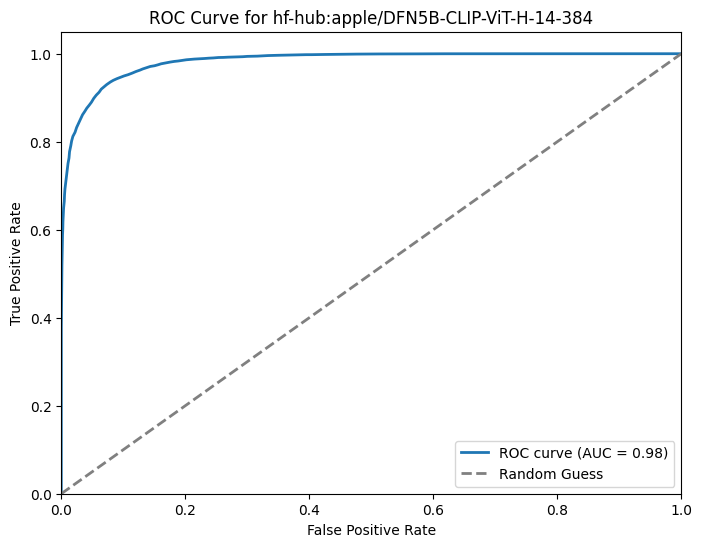

In [22]:
# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr_list, tpr_list)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_list, tpr_list, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {collection_config.model_config.model_name}')
plt.legend(loc="lower right")
plt.show()
